In [1]:
import pandas as pd
import glob 
import numpy as np
import os
import trajectory_planning_helpers as tph
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
from f1tenth_sim.utils.MapData import MapData
from f1tenth_sim.utils.track_utils import RaceTrack, CentreLine


from f1tenth_sim.data_tools.general_plotting.plot_trajectory_analysis import plot_trajectory_analysis
from f1tenth_sim.data_tools.general_plotting.plot_raceline_tracking import plot_raceline_tracking

from f1tenth_sim.data_tools.plotting_utils import *
from f1tenth_sim.run_scripts.run_functions import *
import numpy as np


if os.getcwd().split('/')[-1] == 'Notebooks':
    os.chdir('..')
    print(f'Changed directory to root of repo: {os.getcwd()}')

save_path = 'Data/BenchmarkArticle/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

Changed directory to root of repo: /home/benjy/Documents/RacingRepos/f1tenth_sim


## Training Graphs

In [2]:

seeds = [12, 13, 14]
rewards = ["Progress", "CTH", "TAL"]
train_maps = ["mco", "gbr", "esp", "aut"]

total_training_steps = 50000
resampled_xs = np.linspace(0, total_training_steps, 50000)

avg_training_data = {}
min_training_data = {}
max_training_data = {}
avg_reward_data = {}
min_reward_data = {}
max_reward_data = {}
downsampled_xs = np.linspace(0, total_training_steps, 1000)

training_data = {}
for train_map in train_maps:
    for reward in rewards:
        temp_progress_data = []
        temp_reward_data = []
        for seed in seeds:
            test_id = f"TD3_{reward}_{seed}_{train_map}"

            root_path = f"Logs/EndToEnd/RawData_{test_id}/"
            results = pd.read_csv(root_path + f"TrainingData_{test_id}.csv")
            steps = results["Steps"]
            progresses = results["Progress"]*100

            resampled_progress = np.interp(resampled_xs, steps, progresses)
            temp_progress_data.append(resampled_progress)

            reward_hsitory = np.load(root_path + "RewardHistory.npy")
            resampled_rewards = np.interp(resampled_xs, steps, reward_hsitory)
            temp_reward_data.append(resampled_rewards)

        avg_training_data[f"{reward}_{train_map}"] = np.interp(downsampled_xs, resampled_xs, np.mean(temp_progress_data, axis=0))
        min_training_data[f"{reward}_{train_map}"] = np.interp(downsampled_xs, resampled_xs, np.min(temp_progress_data, axis=0))
        max_training_data[f"{reward}_{train_map}"] = np.interp(downsampled_xs, resampled_xs, np.max(temp_progress_data, axis=0))

        avg_reward_data[f"{reward}_{train_map}"] = np.interp(downsampled_xs, resampled_xs, np.mean(temp_reward_data, axis=0))
        min_reward_data[f"{reward}_{train_map}"] = np.interp(downsampled_xs, resampled_xs, np.min(temp_reward_data, axis=0))
        max_reward_data[f"{reward}_{train_map}"] = np.interp(downsampled_xs, resampled_xs, np.max(temp_reward_data, axis=0))

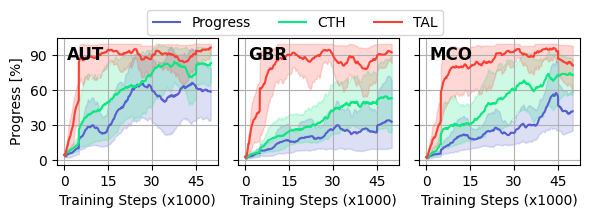

In [3]:

colors = [periwinkle, minty_green, red_orange]
period = 100

plot_maps = ["aut", "gbr", "mco"]
fig, ax = plt.subplots(1, len(plot_maps), figsize=(6, 2), sharex=True, sharey=True)
for i, train_map in enumerate(plot_maps):
    axs = ax[i]
    for j, reward in enumerate(rewards):
        ys = avg_training_data[f"{reward}_{train_map}"]
        ys = true_moving_average(ys, period)
        ax[i].plot(downsampled_xs/1e3, ys, label=reward, color=colors[j])
        ys_min = true_moving_average(min_training_data[f"{reward}_{train_map}"], period)
        ys_max = true_moving_average(max_training_data[f"{reward}_{train_map}"], period)
        axs.fill_between(downsampled_xs/1e3, ys_min, ys_max, alpha=0.2, color=colors[j])

    axs.text(1, 86, f"{train_map.upper()}", fontdict={"fontsize": 12, "fontweight": "bold"})
    axs.set_xlabel("Training Steps (x1000)")
    axs.grid()
ax[0].set_ylabel("Progress [%]")
ax[0].yaxis.set_major_locator(plt.MaxNLocator(4))
ax[0].xaxis.set_major_locator(plt.MaxNLocator(4))

h, l = ax[0].get_legend_handles_labels()
# fig.legend(h[::2], ["Progress", "CTH", "TAL"], loc="upper center", ncol=3)
# fig.legend(["Progress", "CTH", "TAL"], loc="upper center", ncol=3)
fig.legend(h, ["Progress", "CTH", "TAL"], loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.1))

plt.tight_layout()
plt.savefig(f"{save_path}BenchmarkProgressTraining.pdf", bbox_inches='tight')
plt.savefig(f"{save_path}BenchmarkProgressTraining.svg", bbox_inches='tight')

In [9]:
summary_df = pd.read_csv("Logs/Summary.csv")

map_list = ["aut", "esp", "gbr", "mco"]

avg_data = {}
min_data = {}
max_data = {}
for i, reward in enumerate(rewards):
    for train_map in map_list:
        test_ids = [f"TD3_{reward}_{seed}_{train_map}" for seed in seeds]
        mini_df = summary_df.loc[summary_df.TestID.isin(test_ids)].drop(columns=["TestID", "Vehicle", "VehicleID"])
        avg_data[f"{reward}_{train_map}"] = mini_df.groupby("MapName").mean()

avg_data = pd.concat(avg_data).reset_index().fillna(0)
avg_data["Reward"] = avg_data["level_0"].apply(lambda x: x.split("_")[0])
avg_data["TrainMap"] = avg_data["level_0"].apply(lambda x: x.split("_")[1])
avg_data = avg_data.drop(columns=["level_0", "StdTime"])
avg_data = avg_data.rename(columns={"MapName": "TestMap"})

# print(avg_data)
# avg_data 
# avg_data = avg_data.sort_values(by=["TrainMap", "Reward"])
avg_data.to_csv("Logs/drl_avg_data.csv", index=False)



In [21]:
summary_df = pd.read_csv("Logs/drl_avg_data.csv")

completion_data = summary_df[["TrainMap", "Reward", "AvgTime", "TestMap"]]
time_pivot = completion_data.pivot(index=["TrainMap", "TestMap"], columns="Reward", values="AvgTime")
print(time_pivot)


Reward                  CTH  Progress        TAL
TrainMap TestMap                                
aut      aut      18.013333   16.6100  21.632000
         esp      45.256650    0.0000  52.067567
         gbr      39.778000    0.0000  45.869333
         mco      33.314667   32.6800  40.793333
esp      aut      17.440000    0.0000  21.680000
         esp      41.266667   50.2400  50.216000
         gbr      39.260000    0.0000   0.000000
         mco      34.210000    0.0000   0.000000
gbr      aut      16.860000    0.0000  20.305333
         esp      40.580000    0.0000  47.405333
         gbr      34.749333   27.9200  41.629333
         mco      29.973350   29.6800  38.626667
mco      aut      18.524000   18.7467  20.188000
         esp      44.435333    0.0000  45.448000
         gbr      38.706667    0.0000  39.448000
         mco      33.048900   31.9000  34.958667


In [22]:
summary_df = pd.read_csv("Logs/drl_avg_data.csv")

completion_data = summary_df[["TrainMap", "Reward", "CompletionRate", "TestMap"]]
time_pivot = completion_data.pivot(index=["TrainMap", "TestMap"], columns="Reward", values="CompletionRate")
print(time_pivot)


Reward                 CTH  Progress       TAL
TrainMap TestMap                              
aut      aut      1.000000  0.333333  1.000000
         esp      0.466667  0.000000  0.800000
         gbr      0.466667  0.000000  0.933333
         mco      0.533333  0.066667  0.333333
esp      aut      0.066667  0.000000  0.066667
         esp      1.000000  0.066667  1.000000
         gbr      0.266667  0.000000  0.000000
         mco      0.266667  0.000000  0.000000
gbr      aut      0.133333  0.000000  0.933333
         esp      0.266667  0.000000  1.000000
         gbr      0.733333  0.066667  1.000000
         mco      0.266667  0.066667  1.000000
mco      aut      0.666667  0.200000  0.933333
         esp      0.933333  0.000000  1.000000
         gbr      0.733333  0.000000  1.000000
         mco      0.600000  0.133333  0.933333


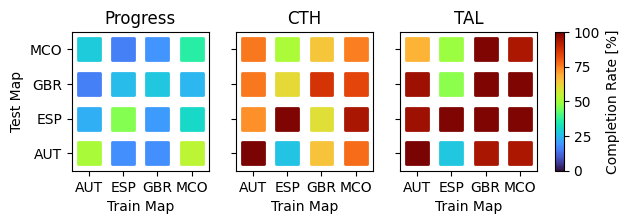

In [68]:
summary_df = pd.read_csv("Logs/drl_avg_data.csv")

completion_data = summary_df[["TrainMap", "Reward", "AvgProgress", "TestMap"]].copy()
completion_data["CompletionRate"] = 100 * completion_data["AvgProgress"]
completion_data["TrainMap"] = completion_data["TrainMap"].apply(lambda x: x.upper())
completion_data["TestMap"] = completion_data["TestMap"].apply(lambda x: x.upper())
# completion_data["CompletionRate"] = 100 * completion_data["CompletionRate"]
size = 250

rewards = ["Progress", "CTH", "TAL"]

fig, ax = plt.subplots(1, 3, figsize=(6, 1.8), sharex=True, sharey=True)
# fig, ax = plt.subplots(1, 3, figsize=(6.5, 2.), sharex=True, sharey=True)
for i, reward in enumerate(rewards):
    axs = ax[i]
    reward_df = completion_data.loc[completion_data.Reward == reward]

    a = axs.scatter(reward_df["TrainMap"], reward_df["TestMap"], s=size, c=reward_df["CompletionRate"], marker='s', linewidth=2, cmap='turbo', vmin=0, vmax=100)

    axs.set_title(reward)
    axs.set_xlabel("Train Map")
    axs.set_xlim(-0.5, 3.5)
    axs.set_ylim(-0.5, 3.5)

ax[0].set_ylabel("Test Map")

ax = ax[2]
cax = fig.add_axes([ax.get_position().x1+0.03, ax.get_position().y0, 0.015, ax.get_position().height])
plt.colorbar(a, cax=cax, label="Completion Rate [%]")

# plt.tight_layout()

plt.savefig(f"{save_path}BenchmarkCompletionRate.pdf", bbox_inches='tight')
plt.savefig(f"{save_path}BenchmarkCompletionRate.svg", bbox_inches='tight')


In [24]:
summary_df = pd.read_csv("Logs/drl_avg_data.csv")

completion_data = summary_df[["TrainMap", "Reward", "AvgProgress", "TestMap"]]
time_pivot = completion_data.pivot(index=["TrainMap", "TestMap"], columns="Reward", values="AvgProgress")
print(time_pivot)

Reward                 CTH  Progress       TAL
TrainMap TestMap                              
aut      aut      0.996333  0.510733  0.996333
         esp      0.730000  0.232033  0.954833
         gbr      0.759400  0.159133  0.956867
         mco      0.761133  0.278367  0.678467
esp      aut      0.264233  0.181300  0.272667
         esp      0.995500  0.463767  0.995367
         gbr      0.607300  0.251767  0.471600
         mco      0.513800  0.158167  0.490367
gbr      aut      0.651167  0.181767  0.937800
         esp      0.595967  0.200333  0.995300
         gbr      0.869867  0.270433  0.995533
         mco      0.645700  0.187633  0.995500
mco      aut      0.776133  0.537367  0.935000
         esp      0.941033  0.305900  0.995433
         gbr      0.833467  0.243167  0.995467
         mco      0.753867  0.360067  0.937467


Reward TrainMap        CTH   Progress        TAL
0           aut  76.113333  27.836667  67.846667
1           esp  51.380000  15.816667  49.036667
2           gbr  64.570000  18.763333  99.550000
3           mco  75.386667  36.006667  93.746667
Reward TrainMap        CTH  Progress        TAL
0           aut  33.314667     32.68  40.793333
1           esp  34.210000      0.00   0.000000
2           gbr  29.973350     29.68  38.626667
3           mco  33.048900     31.90  34.958667


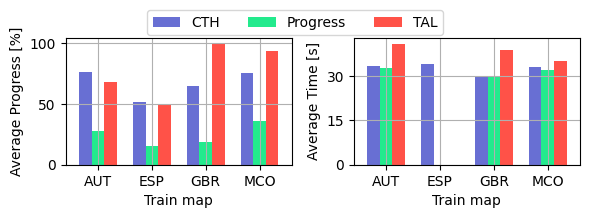

In [10]:

summary_df = pd.read_csv("Logs/drl_avg_data.csv")

fig, ax = plt.subplots(1, 2, figsize=(6, 2.), sharex=True)

xs = np.arange(len(map_list))
width = 0.7
test_map = 'mco'

axs = ax[0]
grouped_df = avg_data.loc[avg_data.TestMap == test_map]
grouped_df = grouped_df[["AvgProgress", "TrainMap", "Reward"]]
grouped_df["AvgProgress"] = grouped_df["AvgProgress"]*100
grouped_df = pd.pivot_table(grouped_df, index="TrainMap", columns="Reward", values="AvgProgress")
grouped_df = grouped_df.reset_index("TrainMap")
print(grouped_df)
grouped_df.plot.bar(ax=axs, color=colors, width=width, position=1, legend=False, alpha=0.9)

axs.set_xticks(xs - width/2)
axs.set_xticklabels([x.upper() for x in map_list], rotation=0)
axs.set_xlabel(f"Train map")
axs.grid()
axs.set_ylabel("Average Progress [%]")

axs = ax[1]
grouped_df = avg_data.loc[avg_data.TestMap == test_map] 
grouped_df = grouped_df[["AvgTime", "TrainMap", "Reward"]]
grouped_df = pd.pivot_table(grouped_df, index="TrainMap", columns="Reward", values="AvgTime")
grouped_df = grouped_df.reset_index("TrainMap")
print(grouped_df)
grouped_df.plot.bar(ax=axs, color=colors, width=width, position=1, legend=False, alpha=0.9)


axs.set_xticks(xs - width/2)
axs.yaxis.set_major_locator(plt.MaxNLocator(4))
axs.set_xticklabels([x.upper() for x in map_list], rotation=0)
axs.set_xlabel(f"Train map")
axs.grid()
axs.set_ylabel("Average Time [s]")
fig.legend(["CTH", "Progress", "TAL"], loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.1))

plt.tight_layout()

plt.savefig(f"{save_path}BenchmarkArticle_TestResults_{test_map}.pdf", bbox_inches="tight")
plt.savefig(f"{save_path}BenchmarkArticle_TestResults_{test_map}.svg", bbox_inches="tight")

/tmp/ipykernel_14134/1040126607.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


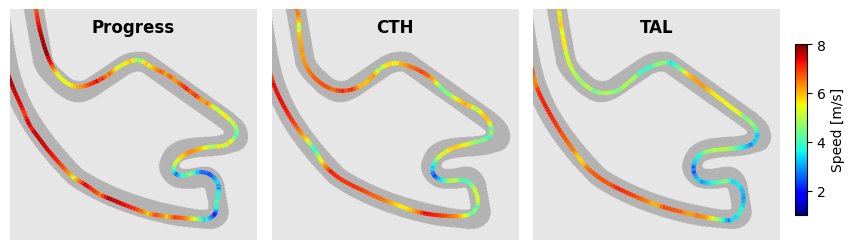

In [8]:
planner_name = "EndToEnd"
seed = 13
train_map = "mco"
test_map = "mco"
test_ids = [f"TD3_{reward}_{seed}_{train_map}" for reward in rewards]
frequency = 25
lap_n = 0

map_data = MapData(test_map)
fig, axs = plt.subplots(1, len(test_ids), figsize=(8, 10), sharex=True, sharey=True)

for i, test_id in enumerate(test_ids):
        data = np.load(f"Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{test_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
        df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])

        plt.sca(axs[i])
        map_data.plot_map_img()

        xs, ys = map_data.xy2rc(df.x, df.y)
        pts = np.array([xs, ys]).T.reshape(-1, 1, 2)
        segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
        norm = plt.Normalize(1, 8)
        lc = LineCollection(segments, cmap='jet', norm=norm)
        lc.set_array(df.speed.values)
        lc.set_linewidth(3)
        line = plt.gca().add_collection(lc)


        plt.axis('off')
        axs[i].set_aspect('equal')
        plt.xlim(650, 1110)
        plt.ylim(70, 500)
        plt.text(0.5, 0.92, f"{rewards[i]}", horizontalalignment='center', verticalalignment='center', transform=axs[i].transAxes, fontsize=12, fontweight="bold")

ax = plt.gca()
cax = fig.add_axes([ax.get_position().x1+0.1, ax.get_position().y0, 0.015, ax.get_position().height])
plt.colorbar(line, cax=cax, label="Speed [m/s]", ticks=[2, 4, 6, 8])
plt.tight_layout()

plt.savefig(f"{save_path}drl_trajectories_{test_map}.svg", bbox_inches='tight')
plt.savefig(f"{save_path}drl_trajectories_{test_map}.pdf", bbox_inches='tight')


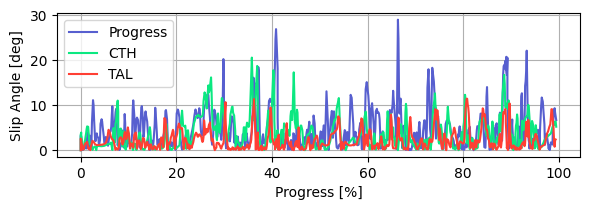

In [12]:
planner_name = "EndToEnd"
seed = 13
train_map = "mco"
test_map = "mco"
test_ids = [f"TD3_{reward}_{seed}_{train_map}" for reward in rewards]
frequency = 25
lap_n = 0

map_data = MapData(test_map)
fig, axs = plt.subplots(1, 1, figsize=(6, 2.2), sharex=True, sharey=True)

for i, test_id in enumerate(test_ids):
        data = np.load(f"Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{test_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
        df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
        df.slip = df.slip.abs() * 180 / np.pi

        plt.plot(df.progress*100, df.slip, label=rewards[i], color=colors[i])

plt.legend()
plt.grid(True)
plt.xlabel("Progress [%]")
plt.ylabel("Slip Angle [deg]")

plt.tight_layout()

plt.savefig(f"{save_path}drl_slip_progress_{test_map}.svg", bbox_inches='tight')
plt.savefig(f"{save_path}drl_slip_progress_{test_map}.pdf", bbox_inches='tight')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


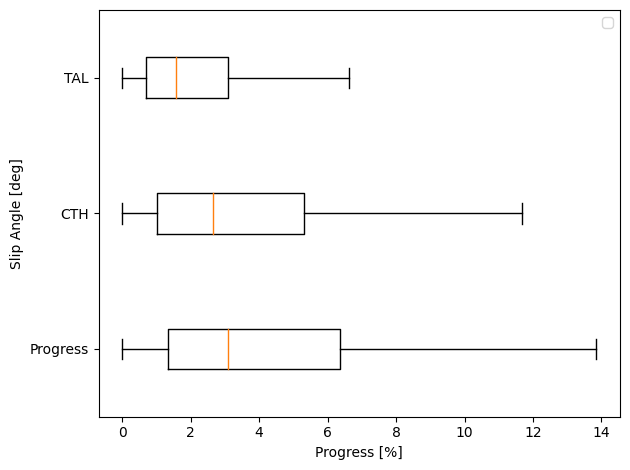

In [16]:
planner_name = "EndToEnd"
seed = 13
train_map = "mco"
test_map = "mco"
test_ids = [f"TD3_{reward}_{seed}_{train_map}" for reward in rewards]
frequency = 25
lap_n = 0

map_data = MapData(test_map)
fig, axs = plt.subplots(1, 1)
# fig, axs = plt.subplots(1, 1, figsize=(6, 2.2), sharex=True, sharey=True)

slips_angles = []
for i, test_id in enumerate(test_ids):
        data = np.load(f"Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{test_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
        df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
        df.slip = df.slip.abs() * 180 / np.pi

        # # plt.plot(df.progress*100, df.slip, label=rewards[i], color=colors[i])
        # plt.sca(axs[i])
        # plt.hist(df.slip, bins=20, color=colors[i], alpha=0.7)
        # plt.grid(True)
        slips_angles.append(df.slip)

plt.boxplot(slips_angles, labels=rewards, showfliers=False, vert=False)

plt.legend()
plt.xlabel("Progress [%]")
plt.ylabel("Slip Angle [deg]")

plt.tight_layout()

plt.savefig(f"{save_path}drl_slip_progress_{test_map}.svg", bbox_inches='tight')
plt.savefig(f"{save_path}drl_slip_progress_{test_map}.pdf", bbox_inches='tight')
